In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from keras.models import Input, Sequential, Model
from keras.layers import Dense, LSTM, TimeDistributed, Masking, Bidirectional, concatenate, Flatten, Dropout
from keras.optimizers import Adam
from sklearn.cluster import KMeans

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


Using TensorFlow backend.


In [2]:
inputfile = '../data/test/mexico_k_2_standard.csv'
profile_file = '../data/profiles.csv'

def get_data():
    profiles_file = pd.read_csv(profile_file)
    profiles_file = profiles_file[['profile_id', 'cwrb_reference_soil_group']]
    data = pd.read_csv(inputfile)
    data = profiles_file.merge(data, how="inner", left_on=[
        'profile_id'], right_on=['profile_id'])

    data = remove_small_classes(data, 15)

    y = data.cwrb_reference_soil_group.astype(str)
    X = data.drop(['cwrb_reference_soil_group'], axis=1)

    return X, y, data

def remove_small_classes(df, min):
    uniques = df.cwrb_reference_soil_group.unique()
    for u in uniques:
        cnt = df[df.cwrb_reference_soil_group == u].shape[0]
        if cnt < min:
            df = df[df.cwrb_reference_soil_group != u]
            print('Deleting {} with {} occurrences'.format(u, cnt))

    return df



def get_data_structured():
    profiles_file = pd.read_csv(profile_file)
    profiles_file = profiles_file[['profile_id', 'cwrb_reference_soil_group']]
    data = pd.read_csv(inputfile)
    data = profiles_file.merge(data, how="inner", left_on=[
        'profile_id'], right_on=['profile_id'])

    X, y, data = get_data()

    # Treat Labels
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_Y = encoder.transform(y)
    dummy_y = np_utils.to_categorical(encoded_Y)

    return X, dummy_y, encoder


def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_accuracy(history):
    plt.clf()
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    

def get_data_recurrent():
    inputfile = '../data/mexico_k_1.csv'
    profile_file = '../data/profiles.csv'
    profiles_file = pd.read_csv(profile_file)
    profiles_file = profiles_file[['profile_id', 'cwrb_reference_soil_group']]
    data = pd.read_csv(inputfile)
    data = profiles_file.merge(data, how="inner", left_on=[
        'profile_id'], right_on=['profile_id'])
    
    # Remove minority classes
    data = data[data['cwrb_reference_soil_group'] !='Plinthosols']
    data = data[data['cwrb_reference_soil_group'] !='Histosols']

    data.fillna(-1., inplace=True)
    profile_data, layer_data, y = treat_data(data)

    # Treat Labels
    encoder = LabelEncoder()
    encoder.fit(y)
    encoded_Y = encoder.transform(y)
    dummy_y = np_utils.to_categorical(encoded_Y)

    return profile_data, layer_data, dummy_y, encoder



def treat_data(data):
    profile_data = []
    layer_data = []
    profile_ids = data.profile_id.unique()
    max_n_layers = data.profile_id.value_counts().head(1).values[0]
    # All except latitude longitude profile id and class
    features_per_layer = len(data.columns) - 4
    y = []

    for i, id in enumerate(profile_ids):
        if i % 1000 == 0:
            print(i)

        # Find the layers for this profile and sort them
        layers = data[data['profile_id'] == id]
        layers = layers.sort_values(by=['lower_depth'])

        # Add the layer, filling the missing layers with 0
        layer = np.zeros([max_n_layers, features_per_layer])
        for j, l in enumerate(layers.drop(['profile_id', 'cwrb_reference_soil_group', 'latitude', 'longitude'], axis=1).values):
            layer[j] = l
        layer_data.append(layer)

        # Fill the profile data
        profile = layers.iloc[0][['latitude', 'longitude', 'profile_id']]
        profile_data.append(profile.values)

        y.append(layers.iloc[0].cwrb_reference_soil_group)

    return np.array(profile_data).reshape(len(profile_data), 3), np.array(layer_data), y

# Add Results from Classifiers

In [3]:
# Create DataSets

random = np.random.randint(100)
X, y, final_data = get_data()

# Tree Based
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=random)

# Neural Network
X_seq, y_seq, encoder_seq = get_data_structured()

bools_seq = []
for p in X_seq['profile_id']: 
    bools_seq.append(p in list(X_train['profile_id']))

X_train_seq = X_seq[bools_seq]
X_test_seq = X_seq[np.logical_not(bools_seq)]
y_train_seq = y_seq[bools_seq]
y_test_seq = y_seq[np.logical_not(bools_seq)]
#X_seq, y_seq, encoder_seq = get_data_structured()
#X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
#    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=random)

# Recurrent Neural Network
X_rec_profile, X_rec_layer, y_rec, encoder_rec = get_data_recurrent()

bools_rec = []
for p in X_rec_profile[:,2]: 
    bools_rec.append(p in list(X_train['profile_id']))

X_train_profile = X_rec_profile[bools_rec]
X_test_profile = X_rec_profile[np.logical_not(bools_rec)]
X_train_layer = X_rec_layer[bools_rec]
X_test_layer = X_rec_layer[np.logical_not(bools_rec)]
y_train_rec = y_rec[bools_rec]
y_test_rec = y_rec[np.logical_not(bools_rec)]

#X_rec_profile, X_rec_layer, y_rec, encoder_rec = get_data_recurrent()
#X_train_profile, X_test_profile, X_train_layer, X_test_layer, y_train_rec, y_test_rec = train_test_split(
#    X_rec_profile, X_rec_layer, y_rec, test_size=0.2, stratify=y_rec, random_state=random)


Deleting Plinthosols with 6 occurrences
Deleting Histosols with 10 occurrences
Deleting Plinthosols with 6 occurrences
Deleting Histosols with 10 occurrences
0
1000
2000
3000
4000
5000
6000


In [15]:
clf_RF = RandomForestClassifier(min_samples_split=6,
                                n_estimators=1300, min_samples_leaf=2,
                                oob_score=True, class_weight="balanced", n_jobs=2)

start = time.time()
clf_RF.fit(X_train.drop('profile_id', axis=1), y_train)
end = time.time()

preds_RF_val = clf_RF.predict(X_test.drop('profile_id', axis=1))
preds_RF_train = clf_RF.predict(X_train.drop('profile_id', axis=1))

kappa = cohen_kappa_score(preds_RF_val, y_test)
accuracy = accuracy_score(preds_RF_val, y_test)
print(f'Kappa: {kappa}, Accuracy: {accuracy}, Time: {end-start}')


Kappa: 0.4861903014607548, Accuracy: 0.5344699777613047, Time: 15.246674299240112


In [5]:
clf_XGB = XGBClassifier(n_estimators=300, min_child_weight=7,
                    gamma=0.2, subsample=0.8, colsample_bytree=0.8, n_jobs=-1)

start = time.time()
clf_XGB.fit(X_train.drop('profile_id', axis=1), y_train)
end = time.time()

preds_XGB_val = clf_XGB.predict(X_test.drop('profile_id', axis=1))
preds_XGB_train = clf_XGB.predict(X_train.drop('profile_id', axis=1))

kappa = cohen_kappa_score(preds_XGB_val, y_test)
accuracy = accuracy_score(preds_XGB_val, y_test)
print(f'Kappa: {kappa}, Accuracy: {accuracy}, Time: {end-start}')


Kappa: 0.5145810016275103, Accuracy: 0.5633802816901409, Time: 90.37200999259949


In [6]:
def create_model_linear(layer_data, n_classes):
    model = Sequential()
    model.add(Dense(64, activation="relu",
                    input_shape=(layer_data.shape[1:])))

    model.add(Dense(n_classes, activation='softmax'))

    opt = Adam(lr=0.00001, decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
model = create_model_linear(X_train_seq.drop('profile_id', axis=1), y_train_seq.shape[1])

start = time.time()
history = model.fit(X_train_seq.drop('profile_id', axis=1),
                    y_train_seq, epochs=1500, validation_split=0.1, callbacks=[es])
end = time.time()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4855 samples, validate on 540 samples
Epoch 1/1500
4855/4855 [==============================] - 0s 66us/step - loss: 3.3739 - acc: 0.0371 - val_loss: 3.7053 - val_acc: 0.0315
Epoch 2/1500
4855/4855 [==============================] - 0s 28us/step - loss: 3.2906 - acc: 0.0501 - val_loss: 3.6585 - val_acc: 0.0481
Epoch 3/1500
4855/4855 [==============================] - 0s 24us/step - loss: 3.2124 - acc: 0.0622 - val_loss: 3.6150 - val_acc: 0.0574
Epoch 4/1500
4855/4855 [==============================] - 0s 26us/step - loss: 3.1391 - acc: 0.0787 - val_loss: 3.5750 - val_acc: 0.0722
Epoch 5/1500
4855/4855 [==============================] - 0s 28us/step - loss: 3.0702 - acc: 0.0943 - val_loss: 3.5387 - val_acc: 0.0796
Epoch 6/1500
4855/4855 [==============================] - 0s 25us/step - loss: 3.0056 - acc: 0.1085 - val_loss: 3.5048 - val_acc: 0.0907
Epoch 7/150

4855/4855 [==============================] - 0s 23us/step - loss: 1.9581 - acc: 0.4068 - val_loss: 2.7660 - val_acc: 0.1704
Epoch 57/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.9518 - acc: 0.4064 - val_loss: 2.7574 - val_acc: 0.1704
Epoch 58/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.9456 - acc: 0.4074 - val_loss: 2.7492 - val_acc: 0.1722
Epoch 59/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.9397 - acc: 0.4087 - val_loss: 2.7402 - val_acc: 0.1704
Epoch 60/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.9338 - acc: 0.4076 - val_loss: 2.7320 - val_acc: 0.1667
Epoch 61/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.9282 - acc: 0.4089 - val_loss: 2.7238 - val_acc: 0.1722
Epoch 62/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.9226 - acc: 0.4095 - val_loss: 2.7158 - val_acc: 0.1741
Epoch 63/1500
4855/4855 [=======================

4855/4855 [==============================] - 0s 23us/step - loss: 1.7450 - acc: 0.4404 - val_loss: 2.4642 - val_acc: 0.2241
Epoch 116/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.7429 - acc: 0.4391 - val_loss: 2.4601 - val_acc: 0.2241
Epoch 117/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.7408 - acc: 0.4391 - val_loss: 2.4580 - val_acc: 0.2259
Epoch 118/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.7388 - acc: 0.4400 - val_loss: 2.4555 - val_acc: 0.2259
Epoch 119/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.7367 - acc: 0.4408 - val_loss: 2.4521 - val_acc: 0.2259
Epoch 120/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.7348 - acc: 0.4406 - val_loss: 2.4501 - val_acc: 0.2278
Epoch 121/1500
4855/4855 [==============================] - 0s 24us/step - loss: 1.7328 - acc: 0.4408 - val_loss: 2.4483 - val_acc: 0.2259
Epoch 122/1500
4855/4855 [================

4855/4855 [==============================] - 0s 23us/step - loss: 1.6552 - acc: 0.4521 - val_loss: 2.3633 - val_acc: 0.2370
Epoch 175/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.6540 - acc: 0.4527 - val_loss: 2.3621 - val_acc: 0.2352
Epoch 176/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.6529 - acc: 0.4521 - val_loss: 2.3603 - val_acc: 0.2352
Epoch 177/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.6518 - acc: 0.4523 - val_loss: 2.3594 - val_acc: 0.2352
Epoch 178/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.6507 - acc: 0.4536 - val_loss: 2.3583 - val_acc: 0.2352
Epoch 179/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.6496 - acc: 0.4540 - val_loss: 2.3581 - val_acc: 0.2370
Epoch 180/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.6486 - acc: 0.4538 - val_loss: 2.3567 - val_acc: 0.2370
Epoch 181/1500
4855/4855 [================

4855/4855 [==============================] - 0s 23us/step - loss: 1.6012 - acc: 0.4659 - val_loss: 2.3195 - val_acc: 0.2370
Epoch 234/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.6005 - acc: 0.4659 - val_loss: 2.3198 - val_acc: 0.2370
Epoch 235/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5997 - acc: 0.4659 - val_loss: 2.3189 - val_acc: 0.2370
Epoch 236/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5990 - acc: 0.4665 - val_loss: 2.3180 - val_acc: 0.2370
Epoch 237/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5982 - acc: 0.4674 - val_loss: 2.3186 - val_acc: 0.2370
Epoch 238/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5976 - acc: 0.4667 - val_loss: 2.3179 - val_acc: 0.2370
Epoch 239/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5968 - acc: 0.4678 - val_loss: 2.3176 - val_acc: 0.2352
Epoch 240/1500
4855/4855 [================

4855/4855 [==============================] - 0s 23us/step - loss: 1.5627 - acc: 0.4768 - val_loss: 2.2936 - val_acc: 0.2463
Epoch 293/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5621 - acc: 0.4762 - val_loss: 2.2935 - val_acc: 0.2463
Epoch 294/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5616 - acc: 0.4764 - val_loss: 2.2924 - val_acc: 0.2463
Epoch 295/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5610 - acc: 0.4770 - val_loss: 2.2935 - val_acc: 0.2463
Epoch 296/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5605 - acc: 0.4770 - val_loss: 2.2933 - val_acc: 0.2463
Epoch 297/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5600 - acc: 0.4774 - val_loss: 2.2921 - val_acc: 0.2463
Epoch 298/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5594 - acc: 0.4764 - val_loss: 2.2911 - val_acc: 0.2463
Epoch 299/1500
4855/4855 [================

4855/4855 [==============================] - 0s 23us/step - loss: 1.5333 - acc: 0.4830 - val_loss: 2.2750 - val_acc: 0.2463
Epoch 352/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5328 - acc: 0.4849 - val_loss: 2.2743 - val_acc: 0.2463
Epoch 353/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5324 - acc: 0.4840 - val_loss: 2.2743 - val_acc: 0.2463
Epoch 354/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5320 - acc: 0.4836 - val_loss: 2.2739 - val_acc: 0.2463
Epoch 355/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5315 - acc: 0.4836 - val_loss: 2.2748 - val_acc: 0.2463
Epoch 356/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5311 - acc: 0.4853 - val_loss: 2.2738 - val_acc: 0.2463
Epoch 357/1500
4855/4855 [==============================] - 0s 23us/step - loss: 1.5306 - acc: 0.4849 - val_loss: 2.2734 - val_acc: 0.2463
Epoch 358/1500
4855/4855 [================

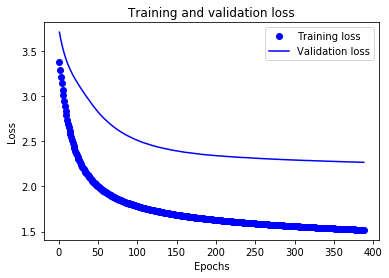

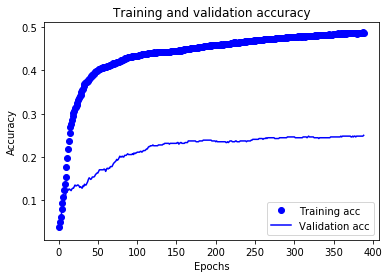

Kappa: 0.38748878703350986, Accuracy: 0.45218680504077097, Time: 44.6206169128418


In [7]:
plot_loss(history)
plot_accuracy(history)

preds_DNN_val = model.predict(X_test_seq.drop('profile_id', axis=1))
preds_DNN_train = model.predict(X_train_seq.drop('profile_id', axis=1))

kappa = cohen_kappa_score(y_test_seq.argmax(axis=1), preds_DNN_val.argmax(axis=1))
accuracy = accuracy_score(y_test_seq.argmax(axis=1), preds_DNN_val.argmax(axis=1))
print(f'Kappa: {kappa}, Accuracy: {accuracy}, Time: {end-start}')


In [8]:
def create_model(profile_data, layer_data, n_classes):
    input_profile = Input( 
        shape=(profile_data.shape[1:]))
    output_profile = Dense(32, activation="relu")(input_profile)

    input_layer = Input(shape=(layer_data.shape[1:]))
    masking_layer = Masking(mask_value=0.0)(input_layer)
    middle_layer = Bidirectional(
        LSTM(16, return_sequences=True))(masking_layer)

    dropout_layer = TimeDistributed(Dropout(0.2))(middle_layer)

    after_dropout_layer = Bidirectional(LSTM(16))(dropout_layer)
    #after_dropout_layer = Bidirectional(NestedLSTM(units=64, depth=2))(dropout_layer)
    #after_dropout_layer = Bidirectional(MultiplicativeLSTM(16))(dropout_layer)

    join_layer = concatenate([output_profile, after_dropout_layer])

    test = Dense(16, activation="relu")(join_layer)

    output_final = Dense(n_classes, activation='softmax')(test)

    opt = Adam(lr=0.0005, decay=1e-6)
    model = Model(inputs=[input_profile, input_layer], outputs=output_final)
    model.compile(optimizer=opt, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model = create_model(X_train_profile[:,:2], X_train_layer, y_train_rec.shape[1])

start = time.time()
history = model.fit([X_train_profile[:,:2], X_train_layer],
                    y_train_rec, epochs=500, validation_split=0.1, callbacks=[es])
end = time.time()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 4855 samples, validate on 540 samples
Epoch 1/500
4855/4855 [==============================] - 6s 1ms/step - loss: 2.8886 - acc: 0.1670 - val_loss: 2.8894 - val_acc: 0.1407
Epoch 2/500
4855/4855 [==============================] - 3s 614us/step - loss: 2.4026 - acc: 0.2737 - val_loss: 2.9939 - val_acc: 0.0870
Epoch 3/500
4855/4855 [==============================] - 3s 577us/step - loss: 2.2314 - acc: 0.3298 - val_loss: 2.9979 - val_acc: 0.0630
Epoch 4/500
4855/4855 [==============================] - 3s 589us/step - loss: 2.1373 - acc: 0.3600 - val_loss: 2.8850 - val_acc: 0.1333
Epoch 5/500
4855/4855 [==============================] - 3s 713us/step - loss: 2.0667 - acc: 0.3740 - val_loss: 2.8607 - val_acc: 0.1333
Epoch 6/500
4855/4855 [==============================] - 4s 836us/step - loss: 2.0124 - acc: 0.3870 - val_loss: 2.9303 - val_acc: 0.1241
Epoch 7/500
4855/4

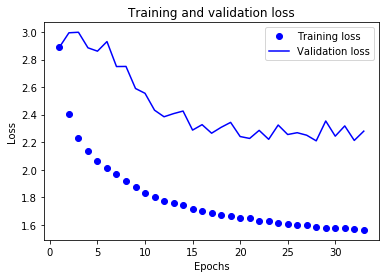

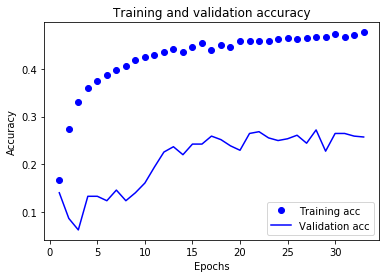

Kappa: 0.37378714102383037, Accuracy: 0.4395848776871757, Time: 117.12031698226929


In [9]:
plot_loss(history)
plot_accuracy(history)


preds_RNN_val = model.predict([X_test_profile[:,:2], X_test_layer])
preds_RNN_train = model.predict([X_train_profile[:,:2], X_train_layer])



kappa = cohen_kappa_score(y_test_rec.argmax(axis=1), preds_RNN_val.argmax(axis=1))
accuracy = accuracy_score(y_test_rec.argmax(axis=1), preds_RNN_val.argmax(axis=1))
print(f'Kappa: {kappa}, Accuracy: {accuracy}, Time: {end-start}')


In [16]:
# Transform from one hot back to label
# DNN
actual_preds_DNN = []
for pred in preds_DNN_val:
    actual_preds_DNN.append(encoder_seq.classes_[np.argmax(pred)])
data_val_dnn = X_test_seq.copy()

# RNN
actual_preds_RNN = []
for pred in preds_RNN_val:
    actual_preds_RNN.append(encoder_rec.classes_[np.argmax(pred)]) 
data_val_rnn = pd.DataFrame(X_test_profile[:,2], columns=['profile_id'])
data_val_rnn.profile_id = data_val_rnn.profile_id.astype('int64')

# Validation tests
data_val = X_test.copy()
data_val['pred_RF'] = preds_RF_val
data_val['pred_XGB'] = preds_XGB_val
data_val_dnn['pred_DNN'] = actual_preds_DNN
data_val_rnn['pred_RNN'] = actual_preds_RNN

data_val = data_val.merge(data_val_rnn, on='profile_id', how="left")
data_val = data_val.merge(data_val_dnn[['profile_id', 'pred_DNN']], on='profile_id', how="left")

data_val['pred_type'] = 'validation'




# DNN
actual_preds_DNN = []
for pred in preds_DNN_train:
    actual_preds_DNN.append(encoder_seq.classes_[np.argmax(pred)])
data_train_dnn = X_train_seq.copy()

# RNN
actual_preds_RNN = []
for pred in preds_RNN_train:
    actual_preds_RNN.append(encoder_seq.classes_[np.argmax(pred)]) 
data_train_rnn = pd.DataFrame(X_train_profile[:,2], columns=['profile_id'])
data_train_rnn.profile_id = data_train_rnn.profile_id.astype('int64')

# Train tests
data_train = X_train.copy()
data_train['pred_RF'] = preds_RF_train
data_train['pred_XGB'] = preds_XGB_train

data_train_dnn['pred_DNN'] = actual_preds_DNN
data_train_rnn['pred_RNN'] = actual_preds_RNN

data_train = data_train.merge(data_train_rnn, on='profile_id', how="left", suffixes=(False,False))
data_train = data_train.merge(data_train_dnn[['profile_id', 'pred_DNN']], on='profile_id', how="left")

data_train['pred_type'] = 'train'

data_all = pd.concat([data_train, data_val])

final_data = final_data.merge(data_all, how="inner")





In [17]:
final_data.head(20)

,profile_id,cwrb_reference_soil_group,upper_depth,lower_depth,tceq_value_avg,clay_value_avg,elcosp_value_avg,orgc_value_avg,phaq_value_avg,sand_value_avg,...,silt_value_avg_150,latitude_150,longitude_150,thickness_150,n_layers,pred_RF,pred_XGB,pred_RNN,pred_DNN,pred_type
0,205798,Regosols,-0.934569,-0.830317,-0.47501,-1.383935,-0.178067,0.007764,-0.338778,1.969068,...,-1.412049,-1.737238,0.816626,1.811789,4,Regosols,Regosols,Arenosols,Regosols,train
1,205801,Regosols,-0.934569,-1.080485,-0.47501,-1.497614,-0.178067,-0.415285,-1.309646,1.969068,...,0.456695,-1.741588,0.832420,-0.236316,2,Regosols,Regosols,Regosols,Regosols,train
2,205803,Cambisols,-0.934569,-1.080485,-0.47501,-0.929220,-0.178067,0.436775,-1.066929,0.719543,...,0.116923,-1.746464,0.992403,1.129087,5,Cambisols,Cambisols,Luvisols,Cambisols,train
3,205811,Regosols,-0.934569,-1.191671,-0.47501,-1.383935,-0.178067,0.319068,-0.581495,1.776833,...,0.116923,-1.759613,0.872343,0.019697,3,Regosols,Regosols,Regosols,Regosols,train
4,205820,Cambisols,-0.934569,-0.941503,-0.47501,-1.383935,-0.178067,0.105857,-0.662401,1.872950,...,-1.242163,-1.773091,0.885003,-0.065641,6,Cambisols,Cambisols,Arenosols,Regosols,train
5,205821,Regosols,-0.934569,-0.941503,-0.47501,-0.247148,-0.178067,0.167053,-0.743306,0.335074,...,-0.222848,-1.773112,0.920485,-0.406992,1,Regosols,Regosols,Regosols,Leptosols,train
6,205826,Regosols,-0.934569,-1.163875,-0.47501,-0.701863,-0.178067,0.158945,-1.066929,1.007895,...,-0.562620,-1.776926,1.001344,-0.577667,2,Regosols,Regosols,Regosols,Regosols,train
7,205828,Regosols,-0.934569,-0.885910,-0.47501,-1.383935,-0.178067,-0.144526,-1.471457,0.815660,...,0.626581,-1.780098,0.921172,-0.236316,1,Regosols,Regosols,Regosols,Regosols,train
8,205829,Regosols,-0.934569,-1.024892,-0.47501,-1.383935,-0.178067,0.269549,-1.228740,0.911777,...,0.456695,-1.781360,0.964588,0.787737,3,Regosols,Regosols,Regosols,Regosols,train
9,205830,Regosols,-0.934569,-0.552351,-0.47501,-1.383935,-0.178067,-0.416471,-0.986023,1.872950,...,-1.412049,-1.782595,0.896370,0.787737,3,Regosols,Regosols,Regosols,Regosols,train


# Add Clustering data

In [18]:
# Add to df
for cluster in range(4, 9):
    print(f'Testing k = {cluster}')
    kmeans = KMeans(n_clusters=cluster, init="k-means++")
    kmeans.fit(final_data.drop(['profile_id','cwrb_reference_soil_group',
                                 'pred_RF', 'pred_XGB', 'pred_RNN','pred_DNN', 'pred_type', 'longitude','latitude'], axis=1))
    final_data[f'cluster_{cluster}']= kmeans.predict(final_data.drop(['profile_id','cwrb_reference_soil_group',
                                 'pred_RF', 'pred_XGB', 'pred_RNN','pred_DNN', 'pred_type', 'longitude','latitude'], axis=1))

Testing k = 4
Testing k = 5
Testing k = 6
Testing k = 7
Testing k = 8


In [19]:
# Add Not normalized lat long

profiles = pd.read_csv(profile_file)
profiles = profiles[['profile_id', 'latitude', 'longitude']]

final_data.rename(index=str, columns={"latitude": "latitude_standard", "longitude": "longitude_standard"}, inplace=True)
final_data = final_data.merge(profiles, how="inner", left_on=[
        'profile_id'], right_on=['profile_id'])


In [20]:
final_data.head(10).columns

Index(['profile_id', 'cwrb_reference_soil_group', 'upper_depth', 'lower_depth',
       'tceq_value_avg', 'clay_value_avg', 'elcosp_value_avg',
       'orgc_value_avg', 'phaq_value_avg', 'sand_value_avg', 'silt_value_avg',
       'latitude_standard', 'longitude_standard', 'thickness',
       'upper_depth_10', 'lower_depth_10', 'tceq_value_avg_10',
       'clay_value_avg_10', 'elcosp_value_avg_10', 'orgc_value_avg_10',
       'phaq_value_avg_10', 'sand_value_avg_10', 'silt_value_avg_10',
       'latitude_10', 'longitude_10', 'thickness_10', 'upper_depth_22.5',
       'lower_depth_22.5', 'tceq_value_avg_22.5', 'clay_value_avg_22.5',
       'elcosp_value_avg_22.5', 'orgc_value_avg_22.5', 'phaq_value_avg_22.5',
       'sand_value_avg_22.5', 'silt_value_avg_22.5', 'latitude_22.5',
       'longitude_22.5', 'thickness_22.5', 'upper_depth_45', 'lower_depth_45',
       'tceq_value_avg_45', 'clay_value_avg_45', 'elcosp_value_avg_45',
       'orgc_value_avg_45', 'phaq_value_avg_45', 'sand_value_av

In [23]:
final_data.to_csv('mexico_k_1_layers_5_with_results.csv', index=False)


# Visualize RF

In [ ]:


estimator = clf_RF.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(X_train.drop('profile_id', axis=1).columns),
                class_names = clf_RF.,
                max_depth=5,
                rounded = True, proportion = False, 
                precision = 2, filled = True)



In [ ]:
sns.barplot(["RF", "DNN","GTB", "RNN"], [15.98,  40.98,89.83, 116.79], color='blue')
#ax.set( ylabel='common ylabel')
plt.ylabel("Time to train (s)")
plt.savefig('time_train.pdf')